In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report


In [3]:
data = pd.read_json('/content/Sarcasm_Headlines_Dataset.json' , lines = True)
data

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


## PreProcessing

In [5]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=None):
    sequences = tokenizer.texts_to_sequences(texts)

    if train == True:
        max_seq_length = np.max(list(map(len, sequences)))

    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_seq_length, padding='post')

    return sequences

In [6]:
def preprocess_inputs(df):
  df = df.copy()

  #droppin article_link
  df = df.drop('article_link', axis = 1)

  # split X and y
  y = df['is_sarcastic']
  X = df['headline']

  # train test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle = True, random_state = 1)

  # create and fit tokenizer
  tokenizer = tf.keras.preprocessing.text.Tokenizer()
  tokenizer.fit_on_texts(X_train)
  print('vocab length', len(tokenizer.word_index) + 1)

  # Get sequence data
  X_train = get_sequences(texts=X_train, tokenizer=tokenizer, train=True)
  X_test = get_sequences(texts=X_test, tokenizer=tokenizer, train=False, max_seq_length=X_train.shape[1])

  print ('sequence length' , X_train.shape[1])

  return X_train, y_train, X_test, y_test


In [7]:
X_train, y_train, X_test, y_test = preprocess_inputs(data)

vocab length 24846
sequence length 40


In [8]:
X_train

array([[ 3579,   481,  1858, ...,     0,     0,     0],
       [ 6496,  4001,     7, ...,     0,     0,     0],
       [ 8490,   343,    11, ...,     0,     0,     0],
       ...,
       [ 4518,  2106, 24841, ...,     0,     0,     0],
       [24843,  1042,  1441, ...,     0,     0,     0],
       [   24,     1,  5280, ...,     0,     0,     0]], dtype=int32)

In [9]:
y_train

21906    1
24781    1
22552    0
17857    0
20032    0
        ..
10955    0
17289    0
5192     0
12172    0
235      0
Name: is_sarcastic, Length: 18696, dtype: int64

In [10]:
y_train.value_counts()

0    10499
1     8197
Name: is_sarcastic, dtype: int64

# Training

In [11]:
inputs = tf.keras.Input(shape=(40,))
x = tf.keras.layers.Embedding(
    input_dim=24846,
    output_dim=64
)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
x = tf.keras.layers.Dense(16, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=[
             'accuracy',
             tf.keras.metrics.AUC(name = 'auc')
    ]
)
print (model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 64)            1590144   
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 128)               327808    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528   

In [12]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(
                   monitor = 'val_loss',
                   patience=3,
                   restore_best_weights=True
               )
    ]
)

Epoch 1/100
468/468 [==============================] - 38s 65ms/step - loss: 0.4252 - accuracy: 0.7879 - auc: 0.8811 - val_loss: 0.3268 - val_accuracy: 0.8575 - val_auc: 0.9354
Epoch 2/100
468/468 [==============================] - 4s 9ms/step - loss: 0.0978 - accuracy: 0.9656 - auc: 0.9931 - val_loss: 0.4089 - val_accuracy: 0.8425 - val_auc: 0.9228
Epoch 3/100
468/468 [==============================] - 4s 9ms/step - loss: 0.0121 - accuracy: 0.9967 - auc: 0.9996 - val_loss: 0.5196 - val_accuracy: 0.8463 - val_auc: 0.9163
Epoch 4/100
468/468 [==============================] - 3s 7ms/step - loss: 0.0030 - accuracy: 0.9991 - auc: 0.9999 - val_loss: 0.8348 - val_accuracy: 0.8452 - val_auc: 0.8913


Accuracy: 85.70%
     AUC: 0.93725
251/251 [==============================] - 1s 2ms/step


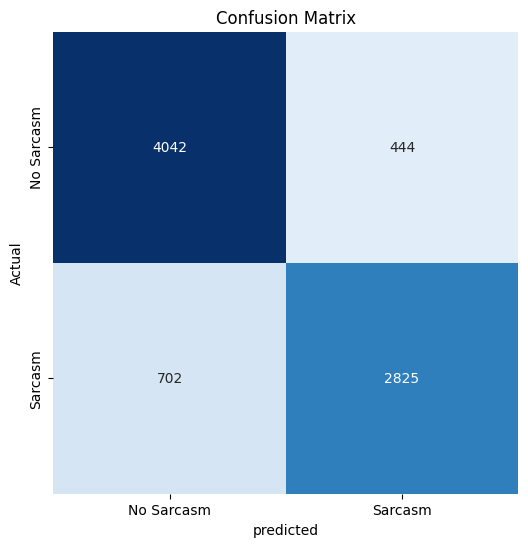

Classification Report:
------------------
               precision    recall  f1-score   support

  No Sarcasm       0.85      0.90      0.88      4486
     Sarcasm       0.86      0.80      0.83      3527

    accuracy                           0.86      8013
   macro avg       0.86      0.85      0.85      8013
weighted avg       0.86      0.86      0.86      8013



In [13]:
results = model.evaluate(X_test, y_test, verbose=0)

print("Accuracy: {:.2f}%".format(results[1] * 100))
print("     AUC: {:.5f}".format(results[2]))

y_pred = np.squeeze(model.predict(X_test)>=0.5).astype(int)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
clr = classification_report(y_test, y_pred, labels=[0,1], target_names = ["No Sarcasm", "Sarcasm"])

plt.figure(figsize = (6,6))
sns.heatmap(cm, annot=True, fmt='g', vmin = 0, cmap = 'Blues', cbar = False)
plt.xticks(ticks = [0.5,1.5], labels=["No Sarcasm", "Sarcasm"])
plt.yticks(ticks = [0.5,1.5], labels=["No Sarcasm", "Sarcasm"])
plt.xlabel('predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()
print("Classification Report:\n------------------\n", clr)

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier=RandomForestClassifier(n_estimators=10).fit(X_train,y_train)
prediction=rf_classifier.predict(X_test)

In [17]:
prediction

array([0, 0, 1, ..., 0, 0, 0])

In [16]:
y_train.value_counts()

0    10499
1     8197
Name: is_sarcastic, dtype: int64

In [18]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print(confusion_matrix(y_test,prediction))
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

[[3579  907]
 [2082 1445]]
0.6269811556221141
              precision    recall  f1-score   support

           0       0.63      0.80      0.71      4486
           1       0.61      0.41      0.49      3527

    accuracy                           0.63      8013
   macro avg       0.62      0.60      0.60      8013
weighted avg       0.62      0.63      0.61      8013



In [19]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [23]:
rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=10,cv=3,verbose=2,
                               random_state=50,n_jobs=1)
### fit the randomized model
rf_randomcv.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END criterion=entropy, max_depth=1000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.8s
[CV] END criterion=entropy, max_depth=1000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.1s
[CV] END criterion=entropy, max_depth=1000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.1s
[CV] END criterion=gini, max_depth=670, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=800; total time=  17.5s
[CV] END criterion=gini, max_depth=670, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=800; total time=  16.9s
[CV] END criterion=gini, max_depth=670, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=800; total time=  16.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_esti

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=780, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=  42.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=780, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=  41.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=780, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=  41.6s
[CV] END criterion=gini, max_depth=340, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=1000; total time=  20.8s
[CV] END criterion=gini, max_depth=340, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=1000; total time=  21.1s
[CV] END criterion=gini, max_depth=340, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=1000; total time=  19.7s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  23.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  19.9s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  19.9s
[CV] END criterion=gini, max_depth=34

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=340, max_features=auto, min_samples_leaf=4, min_samples_split=14, n_estimators=1600; total time=  39.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=340, max_features=auto, min_samples_leaf=4, min_samples_split=14, n_estimators=1600; total time=  40.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=340, max_features=auto, min_samples_leaf=4, min_samples_split=14, n_estimators=1600; total time=  38.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=230, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  10.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=230, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=230, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600; total time=  14.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600; total time=  14.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600; total time=  13.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=50, verbose=2)

In [25]:
rf_randomcv.best_params_

{'n_estimators': 1600,
 'min_samples_split': 14,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 340,
 'criterion': 'gini'}

In [26]:
rf_randomcv

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=50, verbose=2)

In [27]:
best_random_grid=rf_randomcv.best_estimator_

In [28]:
from sklearn.metrics import accuracy_score
y_pred=best_random_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[3647  839]
 [1732 1795]]
Accuracy Score 0.6791463871209285
Classification report:               precision    recall  f1-score   support

           0       0.68      0.81      0.74      4486
           1       0.68      0.51      0.58      3527

    accuracy                           0.68      8013
   macro avg       0.68      0.66      0.66      8013
weighted avg       0.68      0.68      0.67      8013



In [29]:
rf_randomcv.best_params_

{'n_estimators': 1600,
 'min_samples_split': 14,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 340,
 'criterion': 'gini'}

In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': [rf_randomcv.best_params_['criterion']],
    'max_depth': [rf_randomcv.best_params_['max_depth']],
    'max_features': [rf_randomcv.best_params_['max_features']],
    'min_samples_leaf': [rf_randomcv.best_params_['min_samples_leaf'],
                         rf_randomcv.best_params_['min_samples_leaf']+2,
                         rf_randomcv.best_params_['min_samples_leaf'] + 4],
    'min_samples_split': [rf_randomcv.best_params_['min_samples_split'] - 2,
                          rf_randomcv.best_params_['min_samples_split'] - 1,
                          rf_randomcv.best_params_['min_samples_split'],
                          rf_randomcv.best_params_['min_samples_split'] +1,
                          rf_randomcv.best_params_['min_samples_split'] + 2],
    'n_estimators': [rf_randomcv.best_params_['n_estimators'] - 200, rf_randomcv.best_params_['n_estimators'] - 100,
                     rf_randomcv.best_params_['n_estimators'],
                     rf_randomcv.best_params_['n_estimators'] + 100, rf_randomcv.best_params_['n_estimators'] + 200]
}

print(param_grid)

{'criterion': ['gini'], 'max_depth': [340], 'max_features': ['auto'], 'min_samples_leaf': [4, 6, 8], 'min_samples_split': [12, 13, 14, 15, 16], 'n_estimators': [1400, 1500, 1600, 1700, 1800]}


In [ ]:
#### Fit the grid_search to the data
rf=RandomForestClassifier()
grid_search=GridSearchCV(estimator=rf,param_grid=param_grid,cv=3,n_jobs=1,verbose=2)
grid_search.fit(X_train,y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
best_grid=grid_search.best_estimator_

In [ ]:
best_grid

In [ ]:
y_pred=best_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

In [36]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials

In [44]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 120, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200,1300,1500])
    }

In [45]:
space

{'criterion': <hyperopt.pyll.base.Apply at 0x7fc9b5618940>,
 'max_depth': <hyperopt.pyll.base.Apply at 0x7fc9b5619c30>,
 'max_features': <hyperopt.pyll.base.Apply at 0x7fc9b56181f0>,
 'min_samples_leaf': <hyperopt.pyll.base.Apply at 0x7fc9b5619ae0>,
 'min_samples_split': <hyperopt.pyll.base.Apply at 0x7fc9b5619fc0>,
 'n_estimators': <hyperopt.pyll.base.Apply at 0x7fc9b56194e0>}

In [48]:
def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], max_depth = int(space['max_depth']),
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'],
                                 )

    accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
from sklearn.model_selection import cross_val_score
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

100%|██████████| 80/80 [36:22<00:00, 27.28s/trial, best loss: -0.6630825966507101]


{'criterion': 0,
 'max_depth': 60.0,
 'max_features': 3,
 'min_samples_leaf': 0.0035381087469651407,
 'min_samples_split': 0.13533872767286484,
 'n_estimators': 1}

In [52]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200,5:1300,6:1500}


print(crit[best['criterion']])
print(feat[best['max_features']])
print(est[best['n_estimators']])

entropy
None
50


In [54]:
trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], max_depth = int(best['max_depth']),
                                       max_features = feat[best['max_features']],
                                       min_samples_leaf = best['min_samples_leaf'],
                                       min_samples_split = best['min_samples_split'],
                                       n_estimators = est[best['n_estimators']]).fit(X_train,y_train)
predictionforest = trainedforest.predict(X_test)
print(confusion_matrix(y_test,predictionforest))
print(accuracy_score(y_test,predictionforest))
print(classification_report(y_test,predictionforest))
acc5 = accuracy_score(y_test,predictionforest)

[[3545  941]
 [1908 1619]]
0.6444527642580806
              precision    recall  f1-score   support

           0       0.65      0.79      0.71      4486
           1       0.63      0.46      0.53      3527

    accuracy                           0.64      8013
   macro avg       0.64      0.62      0.62      8013
weighted avg       0.64      0.64      0.63      8013

